<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/NityShahU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installations and libraries neccesary to run the code
!pip install preliz
import preliz as pz
import numpy as np
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


We are trying to figure out the probability of Katie Ledecky's 1500 LCM time faster than 15:30:00. I chose this time because that is a little bit faster than the olympic record she set at the most recent 2024 Olympics.

Context: 1500LCM means swimming 1500 meters in a long course pool. These are the ones we typically see on the olympics. 15:30:00 means 15 minutes and 30 seconds to complete this specific event. Katie Ledecky is one of the most respected long distance swimmers in women's swimming. Her main event is this event (1500LCM) and she currently holds the top 20 fastest times in this event. So she is competing soley against herself. I want to see whether she can beat 15:30:00 because this is not the fastest she has swam, but faster than she swam at the 2024 olympics. I want to see if she can beat it even though she is getting older.

Prior: Data wise, out of Ledecky's 16 past official swims in this event under the age of 20, 3 were faster than 15:30:00. This means 3 successes and 13 misses. However, this data is from when she was young. I think that now that she's older and more experienced, there's a better chance that she'll beat 15:30:00, but not too high because it is still a fast standard and hard to beat. Maybe around 35%.

This distribution can be written $p(θ) = Beta(α=8, β=15)$

<Axes: >

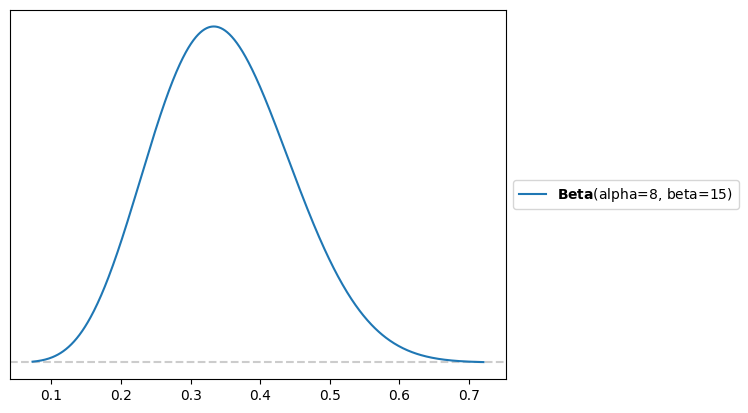

In [6]:
#plotting this beta distribution
pz.Beta(alpha=8,beta=15).plot_pdf()

If we were to make predictions with this prior knowledge, the expected value is the mean, the middle value is the median and the most likely value is the mode.

In [7]:
#store the prior distribution for swims under the threshold percentage
prior = pz.Beta(alpha=8,beta=15)

#preliz does not have a function that returns the mode, so I will use a formula
prior_mode = (prior.alpha - 1)/(prior.alpha + prior.beta - 2)

#the mean first, then median, and finally mode
prior.mean(), prior.median(), prior_mode

(0.34782608695652173, 0.34334499295232174, 0.3333333333333333)

Introducing new info to gain a posterior: Now if we observe her swimming after and including the age of 20, we get more information to improve our guess. Of her 33 1500 LCM (long course meters) swims after the age of 20, 4 were under 15:30:00. This means 29 were not. The likelihood of seeing this given what we already knew is $p(y|θ)$ which means $p($4 makes out of 33$|$ given what we know about the true value $)$

Now, to make actual predictions about the results about her next swims, we can use pymc.

In [11]:
FT_data = np.repeat([1,0], repeats = [4,29])

In [12]:
with pm.Model() as ledecky_model:
  #values taken from our prior
  θ = pm.Beta('θ' , alpha = 8. , beta = 15.)

  #Think of Bernoulli as a stand in for the binomial distribution
  y = pm.Bernoulli('y', p = θ, observed = FT_data)

  #We sample from our posterior because we don't actually
  #have a formula for it. Draws 1000 $θ$s for us to use.
  idata_FT = pm.sample(1000)

<Axes: title={'center': 'θ'}>

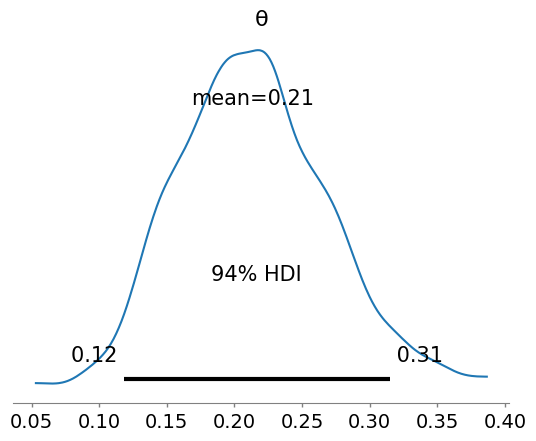

In [15]:
#vizualize the 1000 samples from the pymc model of the posterior
az.plot_posterior(idata_FT)

In this pymc model, the 94% HDI means there's a 94 percent chance of Ledecky's probability of going faster than 15:30:00 being between .12 and .31. The model has a mean of .21. This is a reasonable probability but a little lower than I think. I think she has closer to the higher range of this chance to swim faster than 15:30:00 (closer to .31 than .12) because she is a incredible swimmer and could maintain this speed if she wanted to. The overall shape of it is similar to the anayltic plot from before, just slightly more lumpy because we're running off of a bunch of samples.

In [16]:
#The below function needs to know two things in order to make predictions:
#-the samples from the posterior; these are stored in idata_FT
#-the model that generated those samples, which we called ledecky_model
# The last input tells the function to store those predictions in idata_FT

pm.sample_posterior_predictive(idata_FT, model=ledecky_model, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [17]:
stacked_FT = az.extract(idata_FT, group="posterior_predictive")
stacked_FT.sel(sample=0).sel(draw=0).y.to_series().values

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

This is a prediction for her next 33 swims. 0 means slower than 15:30:00 and 1 means faster. This prediction means nine of her next 33 swims will be faster than 15:30:00. I think that this is a reasonable prediction and that she will have about the same chance at going faster than 15:30:00 as the model suggests.